# Departamento de Polícia de Seattle
## Análise de dados relativo ao uso da força na cidade de Seattle

Aqui iremos explorar os dados disponibilizados pelo departamento de polícia de Seattle para extrair o máximo de informações relevantes.

Nesta primeira etapa iremos carregar as bibliotecas e os dados que usaremos nas nossas análises. Os dados serão também pré-processados para torna-los mais legíveis e facilitar o processo de sumarização das informações.

In [21]:
!pip install geopandas

In [22]:
#encoding:utf-8
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import seaborn as sns; sns.set()

import geopandas as gpd;

In [23]:
# Carregando os dados
data = pd.read_csv('https://raw.githubusercontent.com/alissonSCA/dataset/master/use-of-force.csv', sep=",").set_index('ID');

In [24]:
# Carregando dados geograficos
precinctsGeo = gpd.read_file('https://raw.githubusercontent.com/alissonSCA/dataset/master/spd-precincts.geojson');
beatsGeo = gpd.read_file('https://raw.githubusercontent.com/alissonSCA/dataset/master/spd-beats.geojson');
## Criando o mapa dos setores a partir dos beats
#     Como não foi possível encontrar os dados geográficos dos setores
#     iremos produzi-lo a partir dos beats
#     o nome dos beats é o nome do setor concatenado com um número inteiro entre 1 e 3
sectors = [w[0] for w in beatsGeo['name']];
beatsGeo['sector'] = sectors;
sectorsGeo = beatsGeo.dissolve(by='sector');
sectorsGeo['name'] = [w[0] for w in sectorsGeo['name']];

In [25]:
# Tratar dados faltantes
# Dados faltantes ou não presentes na descrição dos dados serão associados
# a um valor padrão '-'
## Precinct faltantes ou ausentes => '-'
data['Precinct'] = data['Precinct'].fillna('-')
data['Precinct'] = data['Precinct'].str.replace('X','-');
## Setores faltantes ou ausentes => '-'
data['Sector'] = data['Sector'].str.replace('X','-');
data['Sector'] = data['Sector'].str.replace('99','-');
## Beats faltantes ou ausentes => '-'
data['Beat'] = data['Beat'].fillna('-');
data['Beat'] = data['Beat'].str.replace('99','-');
data['Beat'] = data['Beat'].str.replace('XX','-');
## Gênero e raça ausentes => '-'
data['Subject_Race'] = data['Subject_Race'].fillna('-');
data['Subject_Gender'] = data['Subject_Gender'].fillna('-');

# Análise geográfica dos dados
Aqui estudaremos como se dá o uso da força nas diferentes regiões da cidade. Esse estudo será feito em valores absoluto e relativo, como descreveremos em cada caso.

## Como é a distribuição do uso de força dentre as delegacias e os setores?
Os gráficos abaixo mostram o mapa de calor formado pelo número de ocorrências em cada delegacia e em cada setor, respectivamente. Aqui podemos ver que o maior número de ocorrências está na delegacia **W** e nos setores **E** e **K**

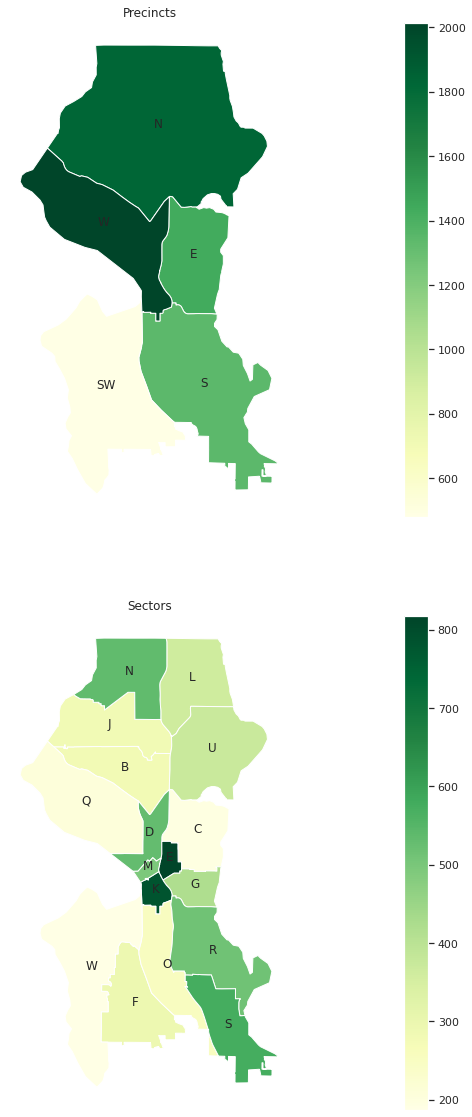

In [26]:
#Como as ocorrencias se distribuem nas delegacias e nos setores
pTotal = data['Precinct'].value_counts();
total = [];
for precName in precinctsGeo['name']:
    total.append(pTotal[precName]);
precinctsGeo['total'] = total;

sTotal = data['Sector'].value_counts();
total = [];
for secName in sectorsGeo['name']:
    total.append(sTotal[secName]);
sectorsGeo['total'] = total;

#Plots
fig, axes = plt.subplots(2, 1, figsize=(40, 20));
fig.subplots_adjust(hspace=0.2, wspace=0.1);

ax = precinctsGeo.plot(ax=axes.flat[0], column='total', cmap='YlGn', legend=True);
ax.set_title('Precincts');
ax.set_axis_off();
for idx, row in precinctsGeo.iterrows():
    ax.annotate(s=row['name'], xy=row['geometry'].centroid.coords[0],horizontalalignment='center');

ax = sectorsGeo.plot(ax=axes.flat[1], column='total', cmap='YlGn', legend=True);
ax.set_title('Sectors');
ax.set_axis_off();
for idx, row in sectorsGeo.iterrows():
    ax.annotate(s=row['name'], xy=row['geometry'].centroid.coords[0],horizontalalignment='center');

## Em cada setor, qual o *beat* com maior número de incidentes?

Deixando um pouco de lado a análise do número de ocorrências na cidade como um todo, focaremos agora na distribuição das ocorrências dentro dos setores. 

Para buscar mensurar o quanto cada beat contribui para o número de ocorrências do setor, construímos um mapa de calor guiado pelo número relativo de ocorrências no beat em relação ao setor.

**Atenção:** Os beats mais escuros são os que contribuem proporcionalmente mais para o número de ocorrências do seu setor, não necessariamente os que possuem mais registros de ocorrência.

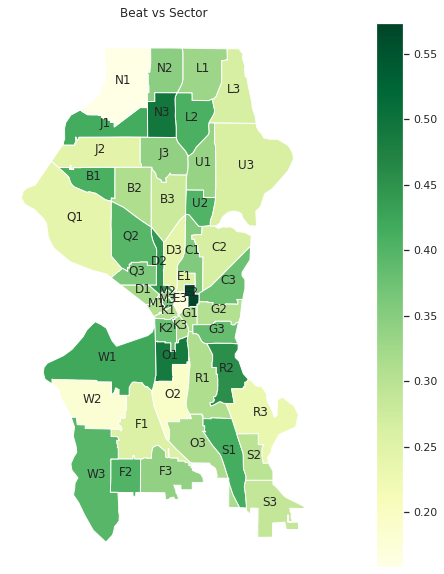

In [27]:
# Quanto um beat é "responsável" pelo resultado do seu setor?
bTotal = data['Beat'].value_counts();
total = [];
relSec = [];
for bName in beatsGeo['name']:
    total.append(bTotal[bName]);
    relSec.append(float(bTotal[bName])/sTotal[bName[0]]);
beatsGeo['total'] = total;
beatsGeo['relSec'] = relSec;

fig, axes = plt.subplots(figsize=(20, 10));
fig.subplots_adjust(hspace=0.2, wspace=0.1);

ax = beatsGeo.plot(ax=axes, column='relSec', cmap='YlGn', legend=True);
ax.set_title('Beat vs Sector');
ax.set_axis_off();
for idx, row in beatsGeo.iterrows():
    ax.annotate(s=row['name'], xy=row['geometry'].centroid.coords[0],horizontalalignment='center');

## Detalhando as ocorrências de um setor específico
Caso tenha interesse em aprofundar o estudo em um setor específico, modifique o valor da variável **S** na célula abaixo para ver um gráfico de pizza do setor.

No exemplo original o setor detalhado é o **E**, que no mapa de calor possui o beat **E2** bem escuro. No gráfico de pizza, a relação parte todo fica bem evidente, tornando mais clara a percepção de o quanto um beat é "maior" que o outro.

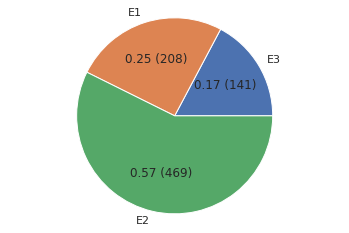

In [28]:
## Explora um setor específico

S = 'E'; # Setor a ser detalhado
v = beatsGeo[beatsGeo['sector']==S]['total'];
l = beatsGeo[beatsGeo['sector']==S]['name'];

fig1, ax1 = plt.subplots()
ax1.pie(v, labels = l, autopct=lambda p: '%.2f (%.0f)' % (p / 100, p * np.sum(v) / 100));
ax1.axis('equal');
plt.show();

## Ranking dos setores segundo o percentual de incidentes "Level 2" em relação ao total de incidentes do respectivo setor

A análise baseada no número de ocorrências pode esconder informações importantes. Aqui estudaremos o percentual de ocorrências "graves" de cada setor.

O gráfico de calor abaixo mostra essa relação.

**Atenção:** a cor mais escura indica que o percentual de ocorrências level 2 daquele setor é maior.Nada podemos afirmar sobre o número absoluto. Por exemplo, o setor **E** é o que possui a maior quantidade de ocorrências level 2, mas não é o mais escuro pois devido ao grande número total de ocorrências, a razão fica menor que a de outros setores.

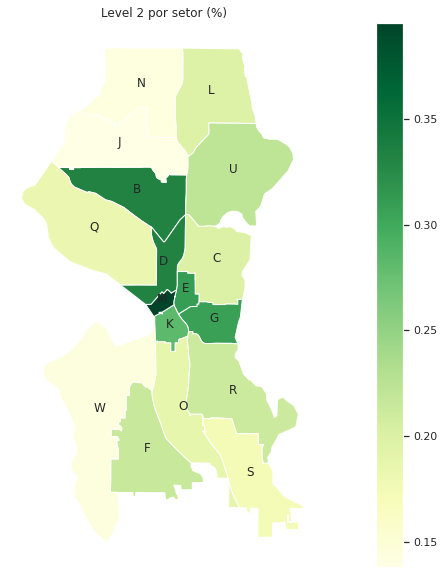

In [29]:
# Em cada setor, qual a proporção entre level 2 vs total do setor?

sTotal = data['Sector'].value_counts();
level2 = [];
for secName in sectorsGeo['name']:
    v = data[data['Sector']==secName]['Incident_Type'].value_counts()['Level 2 - Use of Force'];    
    level2.append(float(v)/sTotal[secName]);
sectorsGeo['level2'] = level2;

fig, axes = plt.subplots(1, 1, figsize=(20, 10));
ax = sectorsGeo.plot(ax=axes, column='level2', cmap='YlGn', legend=True);
ax.set_title('Level 2 por setor (%)');
ax.set_axis_off();
for idx, row in sectorsGeo.iterrows():
    ax.annotate(s=row['name'], xy=row['geometry'].centroid.coords[0],horizontalalignment='center');

No gráfico acima, podemos ver claramente que os setores **B**, **D**, **E**, **G**, **K** e **M** apresentam um percentual de ocorrências level 2 maior que os demais, sendo o setor **M** o com o pior resultado. Tais setores estão em uma faixa continua de território, o que pode ser um indicador importante na tomada de decisões em relação a isso.

## Ocorrências vs razão

No gráfico a seguir procuramos explorar a relação entre o número total de ocorrências de cada setor, divididas por tipo, e a proporção de ocorrências level 2.

Colocamos os setores ordenados pela quantidade total de ocorrências e deixamos as ocorrências level 2 na base do gráfico, para facilitar as comparações.

Além disso, acrescentamos uma linha que marca a proporção de ocorrências level 2 de cada setor. Se as ocorrências level 2 se distribuicem igualmente em todos os setores, teriamos aqui uma linha horizontal, o que não aconteceu. Marcamos também uma linha tracejada vermelha com a média do percentual de ocorrências level 2. Ela nos permite notar que os setores que estão acima da média são exatamente **B**, **D**, **E**, **G**, **K** e **M**, os mesmos que identificamos no mapa de calor.

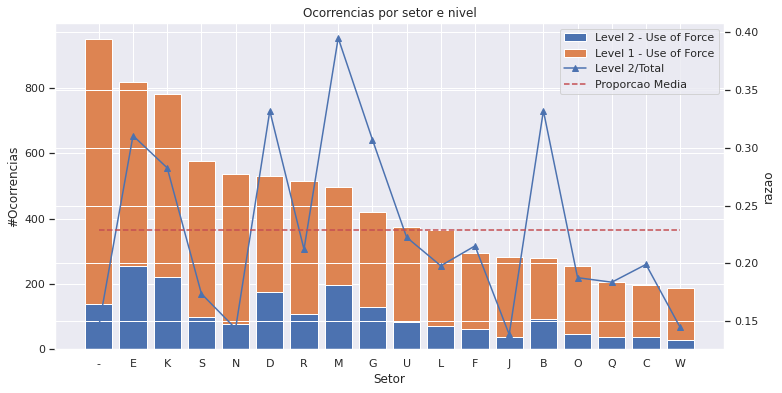

In [30]:
l1Values = [];
l2Values = [];
for sName in sTotal.keys():
    v = data[data['Sector']==sName]['Incident_Type'].value_counts();
    l1Values.append(v['Level 1 - Use of Force']);
    l2Values.append(v['Level 2 - Use of Force']);

fig, ax1 = plt.subplots(figsize=(12, 6));

ind = np.arange(len(l1Values));
p1 = ax1.bar(ind, l2Values);
p2 = ax1.bar(ind, l1Values, bottom=l2Values);
ax1.set_ylabel('#Ocorrencias');
ax1.set_title('Ocorrencias por setor e nivel');
plt.xticks(ind, sTotal.keys());
plt.xlabel('Setor');

ax2 = ax1.twinx()
razao = l2Values/sTotal;
p3 = ax2.plot(ind, razao, 'b^-');
ax2.set_ylabel('razao');

p4 = ax2.plot(ind, np.ones(len(ind))*np.mean(razao), 'r--');

plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Level 2 - Use of Force', 'Level 1 - Use of Force', 'Level 2/Total', 'Proporcao Media'));

plt.show()

# Distribuição dos incidentes no tempo

Aqui buscaremos encontrar uma relação entre a ocorrência de incidentes, especialmente os de level 2, e o periodo em que aconteceram. Para isso, estudaremos como a quantidade de ocorrências de cada tipo se distribuem ao longo dos dias da semana e ao longo das horas do dia. Seria interessante identificar momentos críticos onde poderiam ser concentrados a maioria do esforço.

## Ocorrências por dia da semana

Constuimos um gráfico que nos permite visualizar o número de ocorrências total e level 2 em cada dia da semana. Notamos que todas as barras são praticamente do mesmo tamanho, indicando que não há uma correlação muito forte entre o dia da semana e a ocorrência de incidentes (sejam eles level 1 ou level 2).

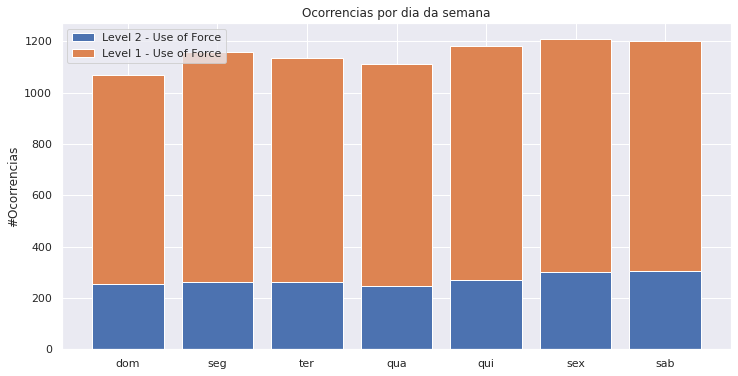

In [31]:
data['w_day'] = [pd.to_datetime(D, yearfirst=True).weekday() for D in data['Occured_date_time']];

l1Values = [];
l2Values = [];
for wd in [0,1,2,3,4,5,6]:
    v = data[data['w_day']==wd]['Incident_Type'].value_counts();
    l1Values.append(v['Level 1 - Use of Force']);
    l2Values.append(v['Level 2 - Use of Force']);
    
fig, ax1 = plt.subplots(figsize=(12, 6));

ind = np.arange(len(l1Values));
p1 = ax1.bar(ind, l2Values);
p2 = ax1.bar(ind, l1Values, bottom=l2Values);
ax1.set_ylabel('#Ocorrencias');
ax1.set_title('Ocorrencias por dia da semana');
wDayName = ['dom','seg','ter','qua','qui','sex','sab'];
plt.xticks(ind, wDayName);

plt.legend((p1[0], p2[0]), ('Level 2 - Use of Force', 'Level 1 - Use of Force'));

## Ocorrências ao longo do dia

No gráfico abaixo vemos como as ocorrências de cada tipo se distribuem ao longo das horas do dia. Podemos notar que há uma queda significativa entre 3 e 11 horas além de outras flutuações de menor intensidade em outros períodos. A partir das 20 horas o número de ocorrencias se mantém bem elevado.

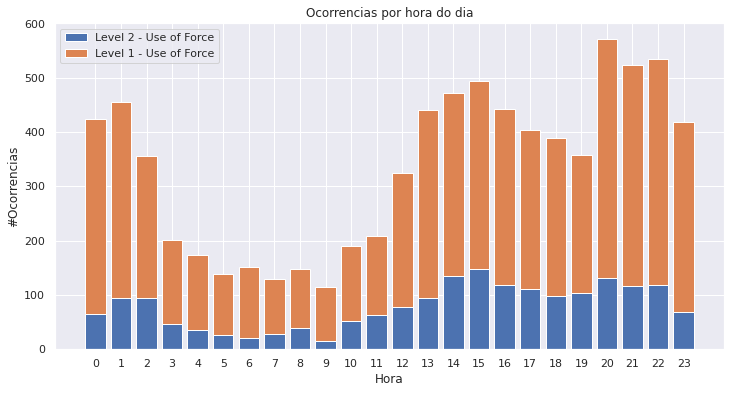

In [32]:
data['hour'] = [pd.to_datetime(D, yearfirst=True).hour for D in data['Occured_date_time']];

l1Values = [];
l2Values = [];
for h in np.unique(data['hour']):
    v = data[data['hour']==h]['Incident_Type'].value_counts();
    l1Values.append(v['Level 1 - Use of Force']);
    l2Values.append(v['Level 2 - Use of Force']);

fig, ax1 = plt.subplots(figsize=(12, 6));

ind = np.arange(len(l1Values));
p1 = ax1.bar(ind, l2Values);
p2 = ax1.bar(ind, l1Values, bottom=l2Values);
ax1.set_ylabel('#Ocorrencias');
ax1.set_xlabel('Hora');
ax1.set_title('Ocorrencias por hora do dia');
plt.xticks(ind, np.unique(data['hour']));

plt.legend((p1[0], p2[0]), ('Level 2 - Use of Force', 'Level 1 - Use of Force'));

# Investigação  sobre uso excessivo de força

## Ranking de probabilidade de se envolver em uma ocorrencia level 2

Devido a falta de tempo para uma análise mais abrangente, vamos procurar elencar quais policiais se envolvem em proporcionalmente mais ocorrências level 2. Assim poderiamos restringir a força de trabalho a estes casos.

No gráfico abaixo veremos um histograma onde a altura indica a quantidade de policiais com dado percentual de ocorrências level 2.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


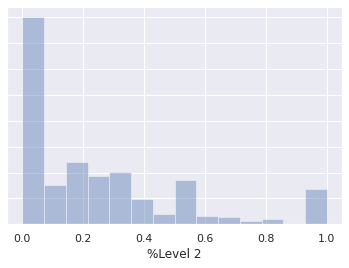

In [33]:
policiais = np.unique(data['Officer_ID']);
policiais = np.delete(policiais, np.where(policiais == 456)); # Remove outlier

total = [];
razao = [];
for pName in policiais:
    v = data[data['Officer_ID']==pName]['Incident_Type'].value_counts();
    if (not ('Level 2 - Use of Force' in v.keys())):        
        v['Level 2 - Use of Force'] = 0; 
    razao.append(float(v['Level 2 - Use of Force'])/np.sum(v));
    total.append(np.sum(v));
    if (np.sum(v) == 80):
        print(pName);

ax = sns.distplot(razao,kde=False);
ax.yaxis.set_ticklabels([]);
plt.xlabel('%Level 2');

Notamos que a grande maioria dos policiais participa de proporcionalmente poucas ocorrências level 2. Assim, existe uma quantidade relativamente pequena de policiais que poderiam ter sua conduta analisada de forma mais detalhada.

No código abaixo vamos listar os policiais que serão investigados. No exemplo original, listamos todos os policiais com pelo menos 60% de ocorências level 2. Para modificar esse índice, modifique a variável **percLim**, no código abaixo.
Alternativamente você também pode definir diretamente a quantidade de policiais que deseja investigar. Para isso, preencha a variável **t** com o valor desejado.

In [34]:
percLim = 0.6;                                  # Listar policiais com mais de percLim% de ocorrências level 2
t = len(policiais[np.array(razao) >= percLim]); # Alternativamente, faça t = número de policiais que deseja listar

ind = np.argsort( np.array(razao) );
print('lista dos %d policiais com proporcionalmente mais ocorrências level 2:\n'%(t))
print(policiais[ind[len(ind)-t:]]);

lista dos 109 policiais com proporcionalmente mais ocorrências level 2:

[1787 1740 1137 1653 1126 4746 1239 2142 1051 2170 1087 2112 1571  828
  691 2175 2299 1680  964 1166 2202 1204  619 1165 1794 1103 1647 1666
  907 1107 1176 1065  908 1731 1042  685  590  698  646  672 1095  246
  245  244  920  924   72  530  928 2158  895  113  963  630  835 4762
  607  624  889  197 1048  598 2486  622  606 2297  257 2227 1272  679
  382 1553 1564  457 1704  676 1688  410 4870 1632 2242 1639 2306 1676
 2252 2320  635  366 2370  519  815 1829  278  281  798  495  446  754
 1774  480  318 1241 1242 1246 2218  348  757  308 1795]


# %Ocorrências level 2 vs #Ocorrências

A medida que um policial participa de mais operações, o número absoluto de ocorrências level 2 que ele participa deve aumentar. O mesmo ocorre com a quantidade relativa? Em outras palavras, um policial "novato" tem mais ou menos probabilidade de se envolver em ocorrências level 2?

Para responder essa pergunta, vamos construir um gráfico com as quantidades de ocorrências no eixo x e a frequencia média de ocorrências level 2 dos policiais no eixo y. A barra azul indica o desvio padrão e a linha amarela é a regressão linear obtida dos dados.

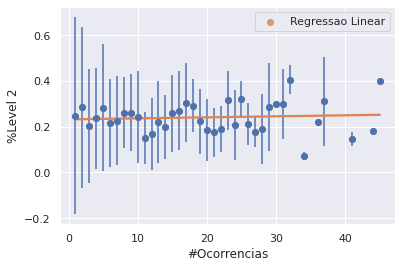

In [35]:
rMean = [];
rStd = [];
for t in np.unique(total):
    i = np.where(total == t)[0];
    r2 = np.array(razao)[i];
    rMean.append(np.mean(r2));
    rStd.append(np.std(r2));
    
plt.errorbar(np.unique(total), rMean, rStd, fmt='o');
plt.xlabel('#Ocorrencias');
plt.ylabel('%Level 2');

ax = sns.regplot(x=np.unique(total), y=rMean, ci=0, label='Regressao Linear');
ax.legend();

Note que a reta de regressão está praticamente horizontal, indicando que aumentar ou diminuir o número de ocorrências que o policial participa não altera significativamente a probabilidade média dele se envolver em um incidente level 2.

# Reincidência

Agora buscaremos estudar a relação entre a reincidência e a ocorrência de incidentes level 2.

## Reicidência nos setores

Vamos comparar o mapa de calor com o percentual de reincidências dos setores com o do percentual de ocorrências level 2 e verificar se eles ficam semelhantes.

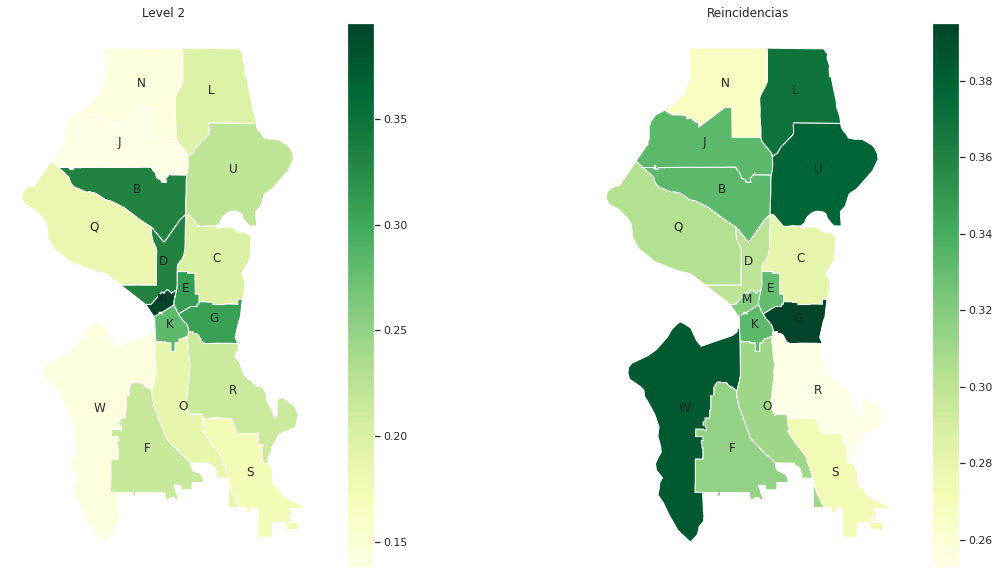

In [36]:
reinc = [];
for secName in sectorsGeo['name']:
    civis, count = np.unique(data[data['Sector']==secName]['Subject_ID'], return_counts=True);
    reinc.append(float(len(civis[count != 1]))/len(civis));    
sectorsGeo['reinc'] = reinc;


fig, axes = plt.subplots(1, 2, figsize=(20, 10));
fig.subplots_adjust(hspace=0.2, wspace=0.1);

ax = sectorsGeo.plot(ax=axes.flat[0], column='level2', cmap='YlGn', legend=True);
ax.set_title('Level 2');
ax.set_axis_off();
for idx, row in sectorsGeo.iterrows():
    ax.annotate(s=row['name'], xy=row['geometry'].centroid.coords[0],horizontalalignment='center');
    
ax = sectorsGeo.plot(ax=axes.flat[1], column='reinc', cmap='YlGn', legend=True);
ax.set_title('Reincidencias');
ax.set_axis_off();
for idx, row in sectorsGeo.iterrows():
    ax.annotate(s=row['name'], xy=row['geometry'].centroid.coords[0],horizontalalignment='center');    

A priori eles não parecem completamente descorrelacionados. Podemos notar, por exemplo, que os setores do centro são relativamente escuro em ambos os mapas. Algumas anomalias, porém, podem ser observadas. A mais gritante parece ser o setor **W**.

Para tirar a dúvida vamos construir uma regressão entre os percentuais de ocorrências level 2 e os percentuais de reincidencias e ver como ela se comporta.

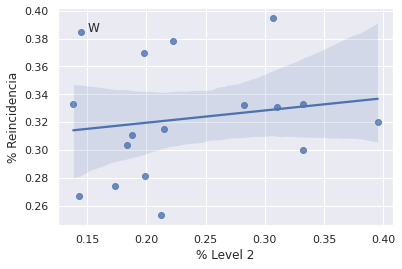

In [37]:
ax = sns.regplot(x=sectorsGeo['level2'], y=sectorsGeo['reinc'], ci=95);
ax.set_xlabel('% Level 2');
ax.set_ylabel('% Reincidencia');
ax.text(0.15, 0.385, 'W');

Podemos ver que há uma correlação positiva, mas não muito intensa. Note que não há setores com alto percentual de ocorrências level 2 e baixo percentual de reincidência. O contrário porém acontece. Podemos ver, por exemplo, o próprio setor **W**, que possui um percentual de incidentes level 2 bem baixo e uma alta taxa de reincidência.

## Reincidência e os civis

A seguir iremos verificar se existe alguma relação entre o número de ocorrências envolvendo um civil e sua probabilidade de se envolver em um incidente level 2. No gráfico abaixo, os pontos representão o percentual médio de ocorrências level 2 entre todos os civis com uma dada quantidade de ocorrências. A barra azul indica o desvio padrão e a linha amarela é a regressão linear obtida dos dados.

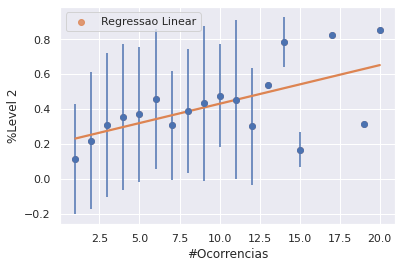

In [38]:
civis = np.unique(data['Subject_ID']);
civis = np.delete(civis, np.where(civis == 1708)); # Remove outlier

total = [];
razao = [];
for cName in civis:
    v = data[data['Subject_ID']==cName]['Incident_Type'].value_counts();
    if (not ('Level 2 - Use of Force' in v.keys())):        
        v['Level 2 - Use of Force'] = 0; 
    razao.append(float(v['Level 2 - Use of Force'])/np.sum(v));
    total.append(np.sum(v));    

rMean = [];
rStd = [];
for t in np.unique(total):
    i = np.where(total == t)[0];
    r2 = np.array(razao)[i];
    rMean.append(np.mean(r2));
    rStd.append(np.std(r2));
    
plt.errorbar(np.unique(total), rMean, rStd, fmt='o');
plt.xlabel('#Ocorrencias');
plt.ylabel('%Level 2');

ax = sns.regplot(x=np.unique(total), y=rMean, ci=0, label='Regressao Linear');
ax.legend();

Podemos ver que existe uma relação clara entre o número de ocorrências e a probabilidade média de participação em incidentes level 2.

# Análise dos resultados

Com essa análise, pudemos identificar algumas linhas de ação visando melhorar o atendimento da população:
1. As regiões centrais merecem uma atenção maior, em especial a delegacia **W**, pois ela possui alto número de ocorrências e também vários dos setores com maior percentual de ocorrências level 2
2. O efetivo policial poderia ser reduzido entre 3 e 11 horas, mas deveria ser reforçado a partir das 20.
3. Como temos uma quantidade relativamente pequena de policiais com alto percentual de ocorrências level 2, estes poderiam ser destinados a tarefas internas e\ou trabalhar em horários e locais com menor número de ocorrências, assim mesmo que mantenha o mesmo percentual de incidentes level 2, o número absoluto iria diminuir.
4. Devido a clara relação entre reincidência e incidentes mais graves, recomenda-se a prefeitura a criação de políticas sociais de acompanhamento dos civis envolvidos em ocorrências. Com isso, buscamos reinceri-lo na sociedade e reduzir o indice de reincidência e, consequentemente, de ocorrências level 2
5. As análises específicas para cada setor devem ser enviados aos responsáveis, para auxilia-los na sua tomada de decisão.
6. Por último, recomendamos um estudo específico para cada delegacia e setor, para tentar identificar características específicas de cada região da cidade que possa ter sido diluída na análise global que fizemos.